In [1]:
%pylab inline
from scipy.interpolate import interpn
from helpFunctions import surfacePlot
import numpy as np
from multiprocessing import Pool
from functools import partial
import warnings
import math
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the policy funciton 
Vgrid_renting = np.load("Vgrid_renting.npy") 
cgrid_renting = np.load("cgrid_renting.npy") 
bgrid_renting = np.load("bgrid_renting.npy") 
kgrid_renting = np.load("kgrid_renting.npy") 
hgrid_renting = np.load("hgrid_renting.npy") 
Mgrid_renting = np.load("Mgrid_renting.npy") 
Hgrid_renting = np.load("Hgrid_renting.npy") 

V1000 = np.load("Vgrid1000.npy")
V1500 = np.load("Vgrid1500.npy")
V2000 = np.load("Vgrid2000.npy")
V750 = np.load("Vgrid750.npy")
V300 = np.load("Vgrid300.npy")
V100 = np.load("Vgrid100.npy")

cgrid1000 = np.load("cgrid1000.npy")
bgrid1000 = np.load("bgrid1000.npy")
kgrid1000 = np.load("kgrid1000.npy")
igrid1000 = np.load("igrid1000.npy")
qgrid1000 = np.load("qgrid1000.npy")

cgrid1500 = np.load("cgrid1500.npy")
bgrid1500 = np.load("bgrid1500.npy")
kgrid1500 = np.load("kgrid1500.npy")
igrid1500 = np.load("igrid1500.npy")
qgrid1500 = np.load("qgrid1500.npy")

cgrid2000 = np.load("cgrid2000.npy")
bgrid2000 = np.load("bgrid2000.npy")
kgrid2000 = np.load("kgrid2000.npy")
igrid2000 = np.load("igrid2000.npy")
qgrid2000 = np.load("qgrid2000.npy")

cgrid750 = np.load("cgrid750.npy")
bgrid750 = np.load("bgrid750.npy")
kgrid750 = np.load("kgrid750.npy")
igrid750 = np.load("igrid750.npy")
qgrid750 = np.load("qgrid750.npy")


indexH = [750, 1000, 1500, 2000]
cgrid = [cgrid100, cgrid300, cgrid750, cgrid1000, cgrid1500, cgrid2000]
bgrid = [bgrid100, bgrid300, bgrid750, bgrid1000, bgrid1500, bgrid2000]
kgrid = [kgrid100, kgrid300, kgrid750, kgrid1000, kgrid1500, kgrid2000]
igrid = [igrid100, igrid300, igrid750, igrid1000, igrid1500, igrid2000]
qgrid = [qgrid100, qgrid300, qgrid750, qgrid1000, qgrid1500, qgrid2000]

In [3]:
# time line 
T_min = 0
T_max = 70
T_R = 45
# constant used to calculate effective housing consumption
kappa = 0.3
# depreciation parameter 
delta = 0.025
# constant cost 
c_h = 0.5
# All the money amount are denoted in thousand dollars
earningShock = [0.8,1.2]
# Define transition matrix of economical states
# GOOD -> GOOD 0.8, BAD -> BAD 0.6
Ps = np.array([[0.6, 0.4],[0.2, 0.8]])
# current risk free interest rate
# r_b = np.array([0.01 ,0.03]) modify the risk free return 
r_b = np.array([0.03, 0.05])
# stock return depends on current and future econ states
# r_k = np.array([[-0.2, 0.15],[-0.15, 0.2]])
r_k = np.array([[-0.15, 0.20],[-0.15, 0.20]])
# expected return on stock market
# r_bar = 0.0667
r_bar = 0.02
# probability of survival
Pa = np.load("prob.npy")
# deterministic income
detEarning = np.load("detEarning.npy")
# probability of employment transition Pe[s, s_next, e, e_next]
Pe = np.array([[[[0.3, 0.7], [0.1, 0.9]], [[0.25, 0.75], [0.05, 0.95]]],
               [[[0.25, 0.75], [0.05, 0.95]], [[0.2, 0.8], [0.01, 0.99]]]])
# tax rate before and after retirement
tau_L = 0.2
tau_R = 0.1
# constant state variables: Purchase value 250k, down payment 50k, mortgage 200k, interest rate 3.6%,
# 55 payment period, 8.4k per period. One housing unit is roughly 1 square feet. Housing price 0.25k/sf 

# some variables associate with 401k amount
Nt = [np.sum(Pa[t:]) for t in range(T_max-T_min)]
Dt = [np.ceil(((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)) for N in Nt]
# mortgate rate 
rh = 0.036
D = [((1+rh)**N - 1)/(rh*(1+rh)**N) for N in range(T_max-T_min)]
# income fraction goes into 401k 
yi = 0.005
# housing price constant 
pt = 250/1000*2
# 30k rent 1000 sf
pr = 30/1000*2

#Define the earning function, which applies for both employment and unemployment, good econ state and bad econ state 
def y(t, x):
    if (len(x) == 7):
        w, n, M, g_lag, e, s, H = x
    else:
        w, n, e, s = x
        
    if t <= T_R:
        welfare = 5
        return detEarning[t] * earningShock[int(s)] * e + (1-e) * welfare
    else:
        return detEarning[t]

#Define the evolution of the amount in 401k account 
def gn(t, n, x, s_next):
    if (len(x) == 7):
        w, n, M, g_lag, e, s, H = x
    else:
        w, n, e, s = x
        
    if t <= T_R and e == 1:
        # if the person is employed, then 5 percent of his income goes into 401k 
        # i = 0.05
        n_cur = n + y(t, x) * yi
    elif t <= T_R and e == 0:
        # if the perons is unemployed, then n does not change 
        n_cur = n
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        n_cur = n - n/Dt[t]
    return (1+r_k[int(s), s_next])*n_cur 


In [4]:
import quantecon as qe
import timeit
mc = qe.MarkovChain(Ps)

H_options = [0, 750, 1000, 1500, 2000]
M_options = [0.2, 0.5, 0.8]
# wealth discretization 
ws = np.array([10,25,50,75,100,125,150,175,200,250,500,750,1000,1500,3000])
w_grid_size = len(ws)
# 401k amount discretization 
ns = np.array([1, 5, 10, 15, 25, 40, 65, 100, 150, 300, 400,1000])
n_grid_size = len(ns)
# Improvement amount 
gs = np.array([0,50,100,200,500,1500])
g_grid_size = len(gs)

def closest(lst, K): 
    '''
        Find the closest value of K in a list lst 
    '''
    lst = np.asarray(lst) 
    idx = (np.abs(lst - K)).argmin() 
    return lst[idx] 

def action_rent(t, x):
    w, n, e, s = x
    points = (ws, ns)
    c = interpn(points, cgrid_renting[:,:,e,s,t], x[:2], method = "nearest", bounds_error = False, fill_value = None)[0]
    b = interpn(points, bgrid_renting[:,:,e,s,t], x[:2], method = "nearest", bounds_error = False, fill_value = None)[0]
    k = interpn(points, kgrid_renting[:,:,e,s,t], x[:2], method = "nearest", bounds_error = False, fill_value = None)[0]
    H = interpn(points, Hgrid_renting[:,:,e,s,t], x[:2], method = "nearest", bounds_error = False, fill_value = None)[0]
    # decide to buy or not to buy a house
    H = H_options[np.sum(H>=np.array(H_options))-1] 
    if H == 0:
        h = interpn(points, hgrid_renting[:,:,e,s,t], x[:2], method = "nearest", bounds_error = False, fill_value = None)[0]
        return (c,b,k,h)
    else:
        M = interpn(points, Mgrid_renting[:,:,e,s,t], x[:2], method = "nearest", bounds_error = False, fill_value = None)[0]
        M = closest(H*M_options, M)
        return (c,b,k,M,H)

def action_own(t, x):
    w, n, M, g_lag, e, s, H = x
    # Mortgage amount, * 0.25 is the housing price per unit
    Ms = np.array([0.01*H,0.05*H,0.1*H,0.2*H,0.3*H,0.4*H,0.5*H,0.6*H,0.7*H,0.8*H]) * pt
    points = (ws,ns,Ms,gs)
    c = interpn(points, cgrid[indexH.index(H)][:,:,:,:,e,s,t], x[:4], method = "nearest", bounds_error = False, fill_value = None)[0]
    b = interpn(points, bgrid[indexH.index(H)][:,:,:,:,e,s,t], x[:4], method = "nearest", bounds_error = False, fill_value = None)[0]
    k = interpn(points, kgrid[indexH.index(H)][:,:,:,:,e,s,t], x[:4], method = "nearest", bounds_error = False, fill_value = None)[0]
    q = interpn(points, qgrid[indexH.index(H)][:,:,:,:,e,s,t], x[:4], method = "nearest", bounds_error = False, fill_value = None)[0]
    if (1-q) <= 0.01:
        q = 1
        i = 0
    else:
        i = interpn(points, igrid[indexH.index(H)][:,:,:,:,e,s,t], x[:4], method = "nearest", bounds_error = False, fill_value = None)[0]
    return (c,b,k,i,q)


def transition_to_rent(x,a,t,s_next):
    '''
        imput a is np array constains all possible actions 
        from x = [w, n, e, s] to x = [w, n, e, s]
    '''
    w, n, e, s = x
    c, b, k, h = a
    # variables used to collect possible states and probabilities
    x_next = []
    prob_next = []
    w_next =  b*(1+r_b[int(s)]) + k*(1+r_k[int(s), s_next])
    n_next = gn(t, n, x, s_next)
    if t >= T_R:
        e_next = 0
        return [w_next, n_next, e_next, s_next]
    else:
        for e_next in [0,1]:
            x_next.append([w_next, n_next, e_next, s_next])
            prob_next.append(Pe[int(s),s_next,int(e),e_next])
    return x_next[np.random.choice(len(prob_next), p = prob_next)]   

def transition_to_own(x,a,t,s_next):
    '''
        imput a is np array constains all possible actions 
        from x = [w, n, e, s] to x = [w, n, M, g=0, e, s, H]
    '''
    w, n, e, s = x
    # variables used to collect possible states and probabilities
    x_next = []
    prob_next = []
    c, b, k, M, H = a
    M_next = M*(1+rh)
    w_next =  b*(1+r_b[int(s)]) + k*(1+r_k[int(s), s_next])
    n_next = gn(t, n, x, s_next)
    if t >= T_R:
        e_next = 0
        return [w_next, n_next, M_next, 0, e_next, s_next, H]
    else:
        for e_next in [0,1]:
            x_next.append([w_next, n_next, M_next, 0, e_next, s_next, H])
            prob_next.append(Pe[int(s),s_next,int(e),e_next])
    return x_next[np.random.choice(len(prob_next), p = prob_next)]

def transition_after_own(x, a, t, s_next):
    '''
    Input: state and action and time
    Output: possible future states and corresponding probability 
    '''
    w, n, M, g_lag, e, s, H = x
    c,b,k,i,q = a
    # variables used to collect possible states and probabilities
    x_next = []
    prob_next = []
    m = M/D[T_max-t]
    M_next = M*(1+rh) - m
    if q == 1:
        g = (1-delta)*g_lag + i
    else:
        g = (1-delta)*g_lag
        
    w_next =  b*(1+r_b[int(s)]) + k*(1+r_k[int(s), s_next])
    n_next = gn(t, n, x, s_next)
    if t >= T_R:
        e_next = 0
        return [w_next, n_next, M_next, g, s_next, e_next, H]
    else:
        for e_next in [0,1]:
            x_next.append([w_next, n_next, M_next, g, s_next, e_next, H])
            prob_next.append(Pe[int(s),s_next,int(e),e_next])
    return x_next[np.random.choice(len(prob_next), p = prob_next)]

In [5]:
'''
    Start with renting: 
    w = 5
    n  = 0
    e = 1
    s = 1
    1000 agents for 1 economy, 500 economies. 
    use numpy array to contain the variable change:
'''
names = ['w', 'n', 'M', 'gs', 'e', 
         's', 'yt', 'c', 'b', 'k', 
         'i', 'q', 'h','live', 'H']
x0 = [5, 0, 1, 1]
numAgents = 1000
numEcons = 500

In [6]:
import quantecon as qe
import random as rd
mc = qe.MarkovChain(Ps)
EconStates = [mc.simulate(ts_length=T_max - T_min, init=0) for _ in range(numEcons)]

def simulation(i):
    track = np.zeros((T_max - T_min,len(names)))
    econState = EconStates[i//numAgents]
    alive = True
    x = x0
    for t in range(1,len(econState)-1):
        if rd.random() > Pa[t]:
            alive = False
        if alive:
            track[t, 13] = 1
            s_next = econState[t+1]
            # if is still renting
            if (len(x) == 4):
                a = action_rent(t,x)
                # continue to rent 
                if (len(a) == 4):
                    # x = [w,n,e,s]
                    # a = [c,b,k,h]
                    track[t, 0] = x[0]
                    track[t, 1] = x[1]
                    track[t, 2] = 0
                    track[t, 3] = 0
                    track[t, 4] = x[2]
                    track[t, 5] = x[3]
                    track[t, 6] = y(t,x)
                    track[t, 7] = a[0]
                    track[t, 8] = a[1]
                    track[t, 9] = a[2]
                    track[t, 10] = 0
                    track[t, 11] = 0
                    track[t, 12] = a[3]
                    x = transition_to_rent(x,a,t,s_next) 
                # switch to own 
                else:
                    # a = [c,b,k,M,H]
                    track[t, 0] = x[0]
                    track[t, 1] = x[1]
                    track[t, 2] = a[3]
                    track[t, 3] = 0
                    track[t, 4] = x[2]
                    track[t, 5] = x[3]
                    track[t, 6] = y(t,x)
                    track[t, 7] = a[0]
                    track[t, 8] = a[1]
                    track[t, 9] = a[2]
                    track[t, 10] = 0
                    track[t, 11] = 1
                    track[t, 12] = a[4]*(1+kappa)
                    track[t, 14] = a[4]
                    x = transition_to_own(x,a,t,s_next)
                    
            # if owning a house already
            else:
                # x = [w,n,M,gs,e,s,H]
                # a = [c,b,k,i,q]
                a = action_own(t,x)
                
                track[t, 0] = x[0]
                track[t, 1] = x[1]
                track[t, 2] = x[2]
                track[t, 3] = x[3]
                track[t, 4] = x[4]
                track[t, 5] = x[5]
                track[t, 6] = y(t,x)
                track[t, 7] = a[0]
                track[t, 8] = a[1]
                track[t, 9] = a[2]
                track[t, 10] = a[3]
                track[t, 11] = a[4]
                track[t, 14] = x[6]
                # calculate housing consumption
                if a[4] == 1:
                    h = x[6] + (1-delta)*x[3] + a[3]
                    Vh = (1+kappa)*h
                else:
                    h = x[6] + (1-delta)*x[3]
                    Vh = (1-kappa)*(h-(1-a[4])*x[6])
                track[t, 12] = Vh
                x = transition_after_own(x, a, t, s_next)
    return track

In [7]:
%%time
pool = Pool()
agents = pool.map(simulation, list(range(numAgents*numEcons)))
pool.close()

CPU times: user 14.4 s, sys: 9.04 s, total: 23.4 s
Wall time: 29min 38s


In [8]:
ww = np.zeros((T_max-T_min, numAgents*numEcons))
nn = np.zeros((T_max-T_min, numAgents*numEcons))
MM = np.zeros((T_max-T_min, numAgents*numEcons))
gg = np.zeros((T_max-T_min, numAgents*numEcons))
ee = np.zeros((T_max-T_min, numAgents*numEcons))
ss = np.zeros((T_max-T_min, numAgents*numEcons))
ytyt = np.zeros((T_max-T_min, numAgents*numEcons))
cc = np.zeros((T_max-T_min, numAgents*numEcons))
hh = np.zeros((T_max-T_min, numAgents*numEcons))
bb = np.zeros((T_max-T_min, numAgents*numEcons))
kk = np.zeros((T_max-T_min, numAgents*numEcons))
ii = np.zeros((T_max-T_min, numAgents*numEcons))
qq = np.zeros((T_max-T_min, numAgents*numEcons))
live = np.zeros((T_max-T_min, numAgents*numEcons))
HH = np.zeros((T_max-T_min, numAgents*numEcons))

In [9]:
def separateAttributes(agents):
    for i in range(numAgents*numEcons):
        ww[:,i] = agents[i][:,0]
        nn[:,i] = agents[i][:,1]
        MM[:,i] = agents[i][:,2]
        gg[:,i] = agents[i][:,3]
        ee[:,i] = agents[i][:,4]
        ss[:,i] = agents[i][:,5]
        ytyt[:,i] = agents[i][:,6]
        cc[:,i] = agents[i][:,7]
        bb[:,i] = agents[i][:,8]
        kk[:,i] = agents[i][:,9]
        ii[:,i] = agents[i][:,10]
        qq[:,i] = agents[i][:,11]
        hh[:,i] = agents[i][:,12]
        live[:,i] = agents[i][:,13]
        HH[:,i] = agents[i][:,14]
separateAttributes(agents)

In [10]:
def quantileForPeopleWholive(attribute, quantiles = [0.25, 0.5, 0.75]):
    qList = []
    for i in range(69):
        if len(np.where(live[i,:] == 1)[0]) == 0:
            qList.append(np.array([0] * len(quantiles)))
        else:
            qList.append(np.quantile(attribute[i, np.where(live[i,:] == 1)], q = quantiles))
    return np.array(qList)
        
def meanForPeopleWholive(attribute):
    means = []
    for i in range(69):
        if len(np.where(live[i,:] == 1)[0]) == 0:
            means.append(np.array([0]))
        else:
            means.append(np.mean(attribute[i, np.where(live[i,:] == 1)]))
    return np.array(means)

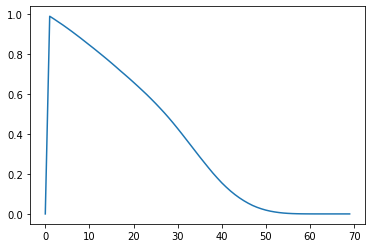

In [11]:
# Population during the entire simulation period
plt.plot(np.mean(live,axis = 1))

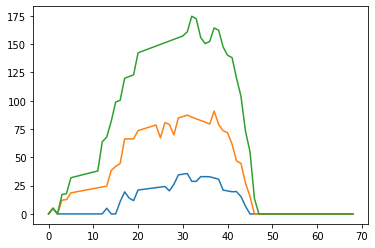

In [12]:
plt.plot(quantileForPeopleWholive(ww))

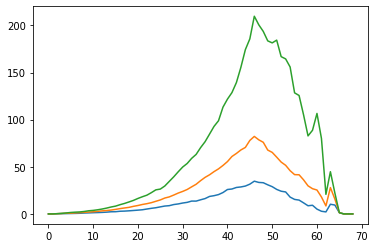

In [13]:
plt.plot(quantileForPeopleWholive(nn))

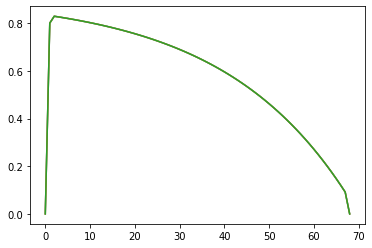

In [14]:
plt.plot(quantileForPeopleWholive(MM))

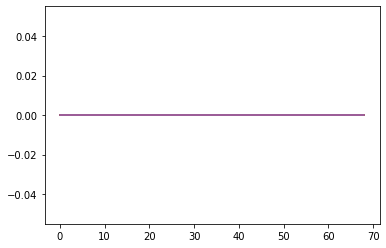

In [15]:
plt.plot(quantileForPeopleWholive(gg, quantiles = [0.1,0.25, 0.5, 0.75,0.99]))

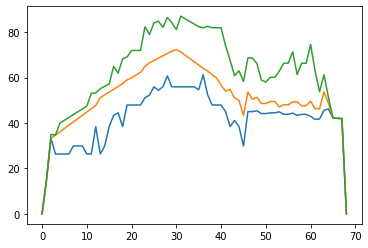

In [16]:
plt.plot(quantileForPeopleWholive(cc))

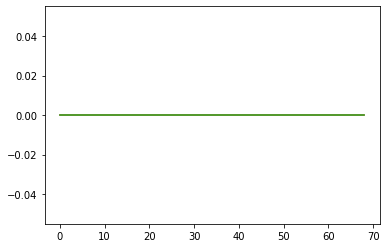

In [17]:
plt.plot(quantileForPeopleWholive(bb))

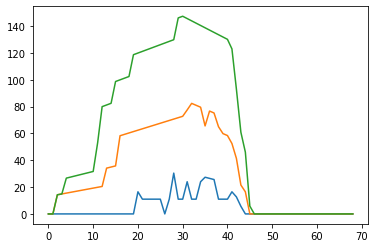

In [18]:
plt.plot(quantileForPeopleWholive(kk))

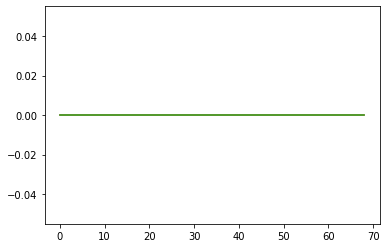

In [19]:
plt.plot(quantileForPeopleWholive(ii))

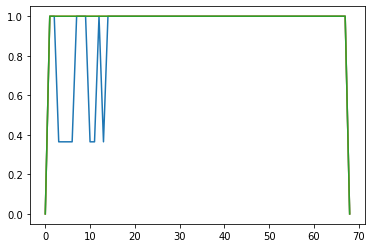

In [20]:
plt.plot(quantileForPeopleWholive(qq))

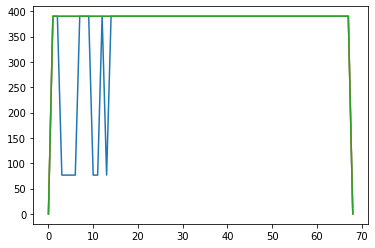

In [21]:
plt.plot(quantileForPeopleWholive(hh))

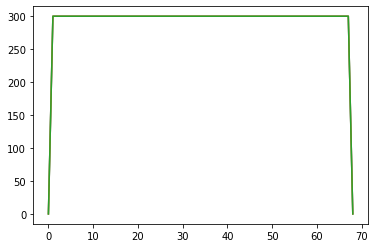

In [22]:
plt.plot(quantileForPeopleWholive(HH))

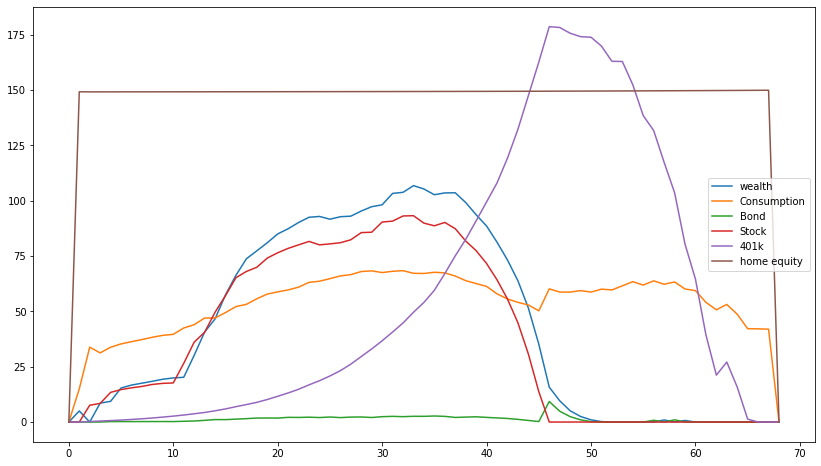

In [23]:
# mean value of the key variables
plt.figure(figsize = [14,8])
plt.plot(meanForPeopleWholive(ww), label = "wealth")
plt.plot(meanForPeopleWholive(cc), label = "Consumption")
plt.plot(meanForPeopleWholive(bb), label = "Bond")
plt.plot(meanForPeopleWholive(kk), label = "Stock")
plt.plot(meanForPeopleWholive(nn), label = "401k")
plt.plot(meanForPeopleWholive(HH*pt) - meanForPeopleWholive(MM), label="home equity")
plt.legend()

In [25]:
for t in range(0,20):
    print(t, np.mean((HH[t,:] == 0) & (live[t,:] == 1)))

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0


In [26]:
for t in range(0,20):
    print(t, np.sum((HH[t,:] == 0) & (live[t,:] == 1)))

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0


In [27]:
np.sum(ee[:,0])

12.0

In [28]:
np.sum(live[:,0])

15.0